In [2]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


2025-03-04 04:11:34.397498: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 04:11:34.400783: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 04:11:34.409836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741061494.430666   16461 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741061494.438202   16461 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 04:11:34.463772: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:

# apple = appl
ticker = 'AAPL'

# download stock data with start and end date
stock_data = yf.download(ticker, start="2010-01-01", end="2023-01-01", interval="1d")

print(stock_data.head())

# open, high, low, close, volume data
# idk anything about stocks but fiwb
data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440332  6.455078  6.391280  6.422878  493729600
2010-01-05  6.451467  6.487880  6.417460  6.458087  601904800
2010-01-06  6.348847  6.477046  6.342226  6.451466  552160000
2010-01-07  6.337111  6.379844  6.291068  6.372321  477131200
2010-01-08  6.379241  6.379843  6.291368  6.328684  447610800


In [4]:

# normalization + preprocessing 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data[:5])


[[0.00364866 0.00320154 0.00391025 0.00381776 0.24841975]
 [0.00385136 0.00339017 0.00406397 0.00388208 0.30702582]
 [0.00381324 0.00332786 0.00362224 0.00328925 0.28007558]
 [0.0033576  0.0027689  0.00332186 0.00322145 0.23942724]
 [0.00310638 0.00276889 0.00332362 0.00346484 0.22343397]]


In [5]:

# create the dataset
def create_dataset(data, time_step=60):
    X, y = [], []
    
    # time_step to predict the next day's price
    for i in range(time_step, len(data)):
        # past time step days
        X.append(data[i-time_step:i])
        # predict the close price
        y.append(data[i, 3])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [6]:

# create dataset with the past 60 days
time_step = 60
X, y = create_dataset(scaled_data, time_step)

print(X.shape)  # (samples, time_steps, features)
print(y.shape)  # (samples,)


(3212, 60, 5)
(3212,)


In [7]:

# 80-20 train test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [8]:

# creating an LSTM model - recurrent neural network in deep learning
model = Sequential()
# layer 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# dropout prevent overfitting
model.add(Dropout(.2))
# layer 2
model.add(LSTM(units=50, return_sequences=False))
# dropout prevent overfitting 2
model.add(Dropout(0.2))
# 1 unit output layer
model.add(Dense(units=1))


2025-03-04 04:11:37.634774: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:

# train/compile
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 2.9444e-04 - val_loss: 0.0035
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.9745e-04 - val_loss: 0.0067
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.3636e-04 - val_loss: 0.0028
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2.3357e-04 - val_loss: 0.0028


In [10]:

# evaluate
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), data.shape[1]-1)), predictions), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), data.shape[1]-1)), y_test.reshape(-1, 1)), axis=1))[:, -1]


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


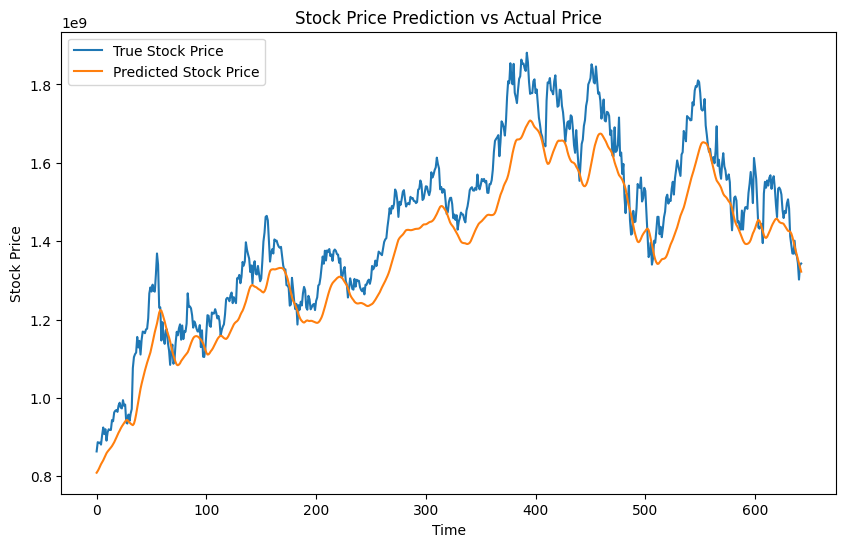

In [11]:


plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="True Stock Price")
plt.plot(predictions, label="Predicted Stock Price")
plt.title("Stock Price Prediction vs Actual Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()

plt.show()
